In [47]:
import numpy as np
import wandb

In [139]:
''' MLP class  '''

class MLP:
    ''' Multi-layer perceptron class '''
    ''' input_size, hidden_layers = [sizes of the hidden layers], output_size, epochs, learning_rate, batch_size, activation_function, loss_function '''
    def __init__(self, input_size, hidden_layers, output_size, epochs = 100, learning_rate = 0.01, early_stopping = False,
                 batch_size = 32, activation_function = 'relu', loss_function = 'mse', optimizer = 'sgd', beta = 0.0, 
                 Random_state = None, weight_init = 'he', model_type = 'class_ML', wandb_vaar = True):
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.beta = beta
        self.weight_init = weight_init
        self.model_type = model_type
        self.wandb_vaar = wandb_vaar
        
        self.weights = []
        self.biases = []
        self.loss = []
        self.history = []
        
        np.random.seed(Random_state)
        
        self._initialize_weights()
        
        run_name = f"{self.activation_function}-{self.optimizer}-{self.loss_function}-{self.weight_init}-{self.epochs}-{self.learning_rate}-{self.batch_size}"
        
        # Initialize WandB
        if wandb_vaar:
            wandb.init(
                project="SMAI_A3-MLP", 
                name=run_name,
                config={
                "learning_rate": self.learning_rate,
                "epochs": self.epochs,
                "batch_size": self.batch_size,
                "activation": self.activation_function,
                "optimizer": self.optimizer,
                "input_size": self.input_size,
                "hidden_layer_sizes": self.hidden_layers,
                "output_size": self.output_size,
                "loss_function": self.loss_function,
                "weight_init": self.weight_init,
                "Random_state": Random_state,
                "beta": self.beta,
                "early_stopping": self.early_stopping,
            })
        
    def _initialize_weights(self):
        ''' Initialize weights '''
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layers) - 1):
            if self.weight_init == 'random':
                self.weights.append(np.random.randn(layers[i], layers[i+1]))  # Random initialization
            
            elif self.weight_init == 'he':
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2. / layers[i]))  # He initialization
            
            elif self.weight_init == 'xavier':
                limit = np.sqrt(6 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (layers[i], layers[i+1])))  # Xavier/Glorot initialization
            
            self.biases.append(np.zeros(layers[i+1]))
        
        self.vW = [np.zeros_like(w) for w in self.weights]  # Initialize velocity for weights
        self.vb = [np.zeros_like(b) for b in self.biases]   # Initialize velocity for biases
    
    # Activation functions       
    def relu(self, x):
        ''' ReLU activation function '''
        return np.where(x > 0, x, x * 0.01)
    def relu_derivative(self, x):
        ''' ReLU derivative '''
        return np.where(x > 0, 1, 0.01)
    
    def sigmoid(self, x):
        ''' Sigmoid activation function '''
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x):
        ''' Sigmoid derivative '''
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        ''' Tanh activation function '''
        return np.tanh(x)
    def tanh_derivative(self, x):
        ''' Tanh derivative '''
        return 1 - np.tanh(x)**2
    
    def linear(self, x):
        ''' Linear activation function '''
        return x
    def linear_derivative(self, x):
        ''' Linear derivative '''
        return 1
            
    def _activation(self, activation_function = None):
        ''' Activation function '''
        if activation_function == 'relu':
            return self.relu, self.relu_derivative
        elif activation_function == 'sigmoid':
            return self.sigmoid, self.sigmoid_derivative
        elif activation_function == 'tanh':
            return self.tanh, self.tanh_derivative
        elif activation_function == 'linear':
            return self.linear, self.linear_derivative
        else:
            raise ValueError('Activation function not supported')
    
    # Optimizers
    def mse(self, y, y_pred):
        ''' Mean squared error '''
        return np.mean((y - y_pred)**2)
    def mse_derivative(self, y, y_pred):
        ''' Mean squared error derivative '''
        return 2*(y_pred - y)
    
    def cross_entropy(self, y, y_pred):
        ''' Cross entropy loss '''
        return -np.sum(y * np.log(y_pred))
    
    def cross_entropy_derivative(self, y, y_pred):
        ''' Cross entropy derivative '''
        return (y_pred - y) # / (y_pred * (1 - y_pred) + 1e-6)  
    
    def _loss(self):
        ''' Loss function '''
        if self.loss_function == 'mse':
            return self.mse, self.mse_derivative
        elif self.loss_function == 'cross_entropy':
            return self.cross_entropy, self.cross_entropy_derivative
        else:
            raise ValueError('Loss function not supported')
        
    def _softmax(self, x):
        ''' Softmax activation function '''
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def _one_hot(self, y):
        ''' One-hot encoding '''
        one_hot = np.zeros((y.size, y.max()+1- y.min()))
        for i in range(y.size):
            one_hot[i, y[i] - y.min()] = 1
        return one_hot
    
    def accuracy(y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def confusion_matrix(y_true, y_pred):
        classes = np.unique(y_true)
        matrix = np.zeros((len(classes), len(classes)), dtype=int)

        for i in range(len(y_true)):
            true_idx = np.where(classes == y_true[i])[0][0]
            pred_idx = np.where(classes == y_pred[i])[0][0]
            matrix[true_idx, pred_idx] += 1
        
        return matrix
    
    def recall(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        recall_values = np.diag(matrix) / np.sum(matrix, axis=1)  # TP / (TP + FN)
        recall_values = np.nan_to_num(recall_values)  # Handle division by zero
        return np.mean(recall_values)
    
    def precision(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        precision_values = np.diag(matrix) / np.sum(matrix, axis=0)  # TP / (TP + FP)
        precision_values = np.nan_to_num(precision_values)  # Handle division by zero
        return np.mean(precision_values)
    
    def f1_score(self, y_true, y_pred):
        prec = self.precision(y_true, y_pred)
        rec = self.recall(y_true, y_pred)
        if (prec + rec) == 0:
            return 0
        return 2 * (prec * rec) / (prec + rec)
    
    def model_functions(self):
        if self.model_type == 'class_ML':
            return self.sigmoid, self.sigmoid_derivative
        elif self.model_type == 'class_MC':
            return self._softmax, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            return self._activation(self.activation_function)
    
    # Forward pass
    def forward(self, X):
        ''' Forward pass '''
        activations = [X]
        Z = [X]
        
        activation, _ = self._activation(self.activation_function)
        current_activation = X
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(current_activation, self.weights[i]) + self.biases[i]
            Z.append(z)
            current_activation = activation(z)
            activations.append(current_activation)
            
        # Output layer
        z = np.dot(current_activation, self.weights[-1]) + self.biases[-1]
        Z.append(z)
        
        # Check if the model is for classification or regression
        activation_function, _ = self.model_functions()
        # output_activation = self.relu(z) # Output activation function
        output_activation = activation_function(z) # Output activation function
        activations.append(output_activation)
        self.activations = activations
        
        return Z, activations
    
    # Backward pass
    def backward(self, X, y, Z, activations):
        ''' Backward pass '''
        grads = {}
        m = y.shape[0]
        
        # Activation function
        # activation_function, activation_derivative = self._activation(self.activation_function)
        activation_function, activation_derivative = self.model_functions()
        
        # Loss function
        # loss, loss_derivative = self._loss()
        if self.model_type == 'class_ML':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'class_MC':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            loss, loss_derivative = self.mse, self.mse_derivative
        
        # backprop loss in output layer
        dA = loss_derivative(y, (activations[-1]))
        if self.model_type == 'class_MC':
            # write the backprop with respect to softmax
            dZ = (activations[-1] - y) / m
        else:
            dZ = dA * activation_derivative(Z[-1])
        
        grads["dW" + str(len(self.weights)-1)] = np.dot(activations[-2].T, dZ) / m
        grads["db" + str(len(self.weights)-1)] = np.sum(dZ, axis=0) / m
        
        # backprop hidden layers
        activation_function, activation_derivative = self._activation(self.activation_function)
        for i in range(len(self.weights)-2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * activation_derivative(Z[i+1])
            grads["dW" + str(i)] = np.dot(activations[i].T, dZ) / m
            grads["db" + str(i)] = np.sum(dZ, axis=0) / m
            
        return grads
    
    # update weights using momentum
    def update_weights(self, grads):
        for i in range(len(self.weights)):
            # Update the velocity for weights and biases using momentum
            self.vW[i] = self.beta * self.vW[i] + (1 - self.beta) * grads["dW" + str(i)]
            self.vb[i] = self.beta * self.vb[i] + (1 - self.beta) * grads["db" + str(i)]
            
            # Update the weights and biases using velocity
            self.weights[i] -= self.learning_rate * self.vW[i]
            self.biases[i] -= self.learning_rate * self.vb[i]
            
    # Train the model
    def fit(self, X, y):
        ''' Train the model '''
        for epoch in range(self.epochs):
            self.optimize(X, y)
            
            # Loss
            loss_func, loss_derivative = self._loss()
            self.loss.append(loss_func(y, self.forward(X)[1][-1]))
            
            if self.wandb_vaar:
                wandb.log({"epoch":epoch, "loss": self.loss[-1]})
            
            if self.early_stopping:
                if len(self.loss) > 1 and abs(self.loss[-1] - self.loss[-2]) < 1e-6:
                    print(f"Converged after {epoch+1} epochs")
                    break
        
        if self.wandb_vaar:
            wandb.finish()
            
    # Optimize
    def optimize(self, X, y):
        ''' Optimize the model '''
        if self.optimizer == 'sgd':
            self.sgd(X, y)
        elif self.optimizer == 'mini_batch':
            self.mini_batch(X, y)
        elif self.optimizer == 'full_batch':
            self.batch(X, y)
        else:
            raise ValueError('Optimizer not supported')
    
    def sgd(self, X, y):
        ''' Stochastic gradient descent '''
        for i in range(X.shape[0]):
            Z, activations = self.forward(X[i])
            
            # Adjust the sizes of matrix
            for j in range(len(activations)):
                activations[j] = activations[j].reshape(1, -1)
                Z[j] = Z[j].reshape(1, -1)
            
            grads = self.backward(X[i], y[i].reshape(1,-1), Z, activations)
            self.update_weights(grads)
    
    def mini_batch(self, X, y):
        ''' Mini-batch gradient descent '''
        for i in range(0, X.shape[0], self.batch_size):
            Z, activations = self.forward(X[i:i+self.batch_size])
            grads = self.backward(X[i:i+self.batch_size], y[i:i+self.batch_size], Z, activations)
            self.update_weights(grads)
            
    def batch(self, X, y):
        ''' Batch gradient descent '''
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        self.update_weights(grads)
        
    # Predict
    def predict(self, X):
        ''' Predict '''
        Z, activations = self.forward(X)
        return activations[-1]
    
    # Evaluate
    def evaluate(self, X, y):
        ''' Evaluate '''
        y_pred = self.predict(X)
        loss, _ = self._loss()
        return loss(y, y_pred)
    
    def _compute_loss(self, X, y):
        ''' Compute loss '''
        Z, activations = self.forward(X)
        loss, _ = self._loss()
        return loss(y, activations[-1])
    
    # gradient checks
    def check_gradients(self, X, y):
        ''' Gradient checks '''
        epsilon = 1e-4
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        
        numerical_grads_list = []
        analytical_grads_list = []
        
        # Check gradients
        for i in range(len(self.weights)):
            numerical_grads = np.zeros_like(self.weights[i])
            for j in range(self.weights[i].shape[0]):
                for k in range(self.weights[i].shape[1]):
                    self.weights[i][j, k] += epsilon
                    loss_plus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] -= 2 * epsilon
                    loss_minus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] += epsilon
                    
                    grad = (loss_plus - loss_minus) / (2 * epsilon)
                    numerical_grads[j, k] = grad
            
            # Compare gradients
            numerical_grads_list.extend(numerical_grads.ravel())
            analytical_grads_list.extend(grads["dW" + str(i)].ravel())
            
        # compare the difference between numerical and analytical gradients
        numerical_grads_list = np.array(numerical_grads_list)
        analytical_grads_list = np.array(analytical_grads_list)
        
        difference = np.linalg.norm(numerical_grads_list - analytical_grads_list) / \
            (np.linalg.norm(numerical_grads_list) + np.linalg.norm(analytical_grads_list))
            
        print(f"Gradient difference: {difference}")
        
        if difference < 1e-7 or difference == 0 or np.isnan(difference):
            print("Gradients are correct")
        
        

Converged after 82 epochs
MSE: 2.4313263301974054e-05
Gradient difference: 1.142974952389726e-13
Gradients are correct
[0.020375813993915023, 0.009146352172604982, 0.007860082706849429, 0.006965565408096301, 0.0061702511861193845, 0.005483829005807726, 0.0048979512196275325, 0.004390490339898131, 0.003947914281140858, 0.0035596968149631024, 0.0032175316464672287, 0.002914659295802423, 0.0026473423289913, 0.0024128710950094227, 0.0022025110603108313, 0.0020132817369138594, 0.0018425799818144425, 0.0016882707741372293, 0.001548523866423972, 0.0014217570936818262, 0.0013066147575964814, 0.0012028078201264446, 0.001108136604472595, 0.0010227294618748843, 0.0009445452637193346, 0.0008728413293601236, 0.0008073017873923579, 0.0007474790149612509, 0.0006923677214932621, 0.0006415408842073582, 0.0005946382855460367, 0.0005513352788706566, 0.0005113578705453815, 0.0004746833337511797, 0.00044075517363262806, 0.0004093439530399825, 0.00038025660726279976, 0.0003533163203572517, 0.000328360891781

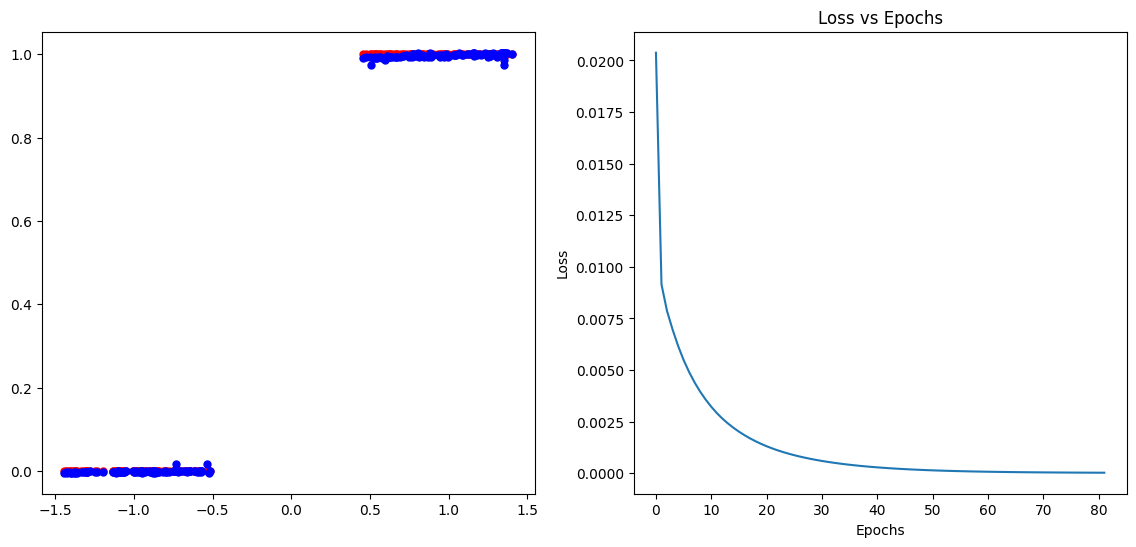

In [140]:
# Test the MLP
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# make 2 clusters around (0, 0) and (1, 1)
X = np.random.uniform(0, 1, (100, 2))
y = np.zeros((100, 1))

X[50:] += 2
y[50:] = 1
# y[:] -= 0.5

# Normalize the data
X = (X - np.mean(X, axis = 0)) / np.std(X, axis = 0)

mlp = MLP(2, [3,3], 1, epochs = 1000, learning_rate = 0.1, batch_size = 16, activation_function = 'relu', early_stopping=True,
          loss_function = 'mse', optimizer = 'mini_batch', beta = 0.0, Random_state=4, model_type='regression', wandb_vaar=False)
# mlp = MLP(2, [3,3], 1, epochs = 1000, learning_rate = 0.1, batch_size = 16, activation_function = 'relu', early_stopping=True,
#           loss_function = 'mse', optimizer = 'sgd', beta = 0.9, Random_state=4)

mlp.fit(X, y)

print(f"MSE: {mlp.evaluate(X, y)}")

# print(mlp.predict(X))

# check gradients
mlp.check_gradients(X, y)

print(mlp.loss)
print(len(mlp.loss))

# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(X, y, 'ro', markersize=5)
plt.plot(X, mlp.predict(X), 'bo', markersize=5)

# plot the loss
plt.subplot(122)
plt.plot(mlp.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


MSE: 2.7695080999576466e-05


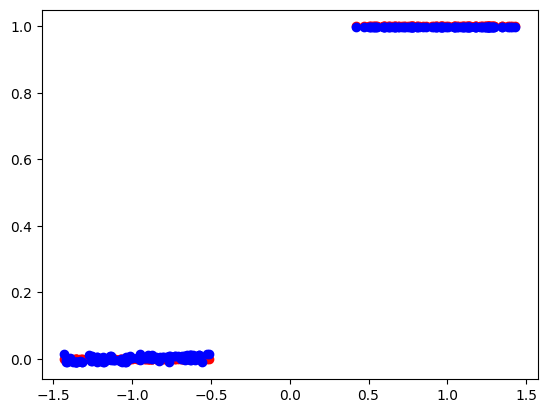

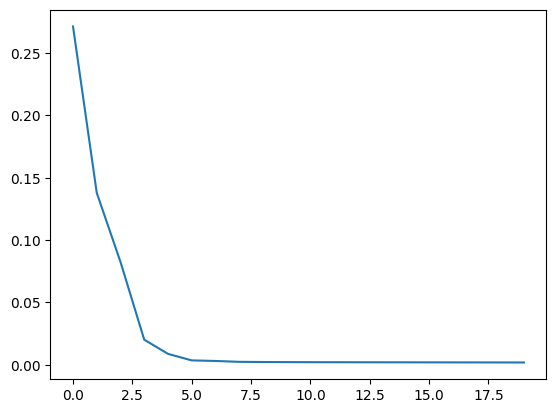

In [50]:
# load the sklearn Neural Nets
from sklearn.neural_network import MLPRegressor, MLPClassifier
clf = MLPRegressor(hidden_layer_sizes=(3, 3), activation='relu', solver='sgd', alpha=0.01, batch_size=16, 
                    learning_rate='constant', learning_rate_init=0.1, max_iter=1000, random_state=None, tol=1e-4, verbose=False)

# fit the model
clf.fit(X, y.ravel())

# predict
y_pred = clf.predict(X)

# evaluate
from sklearn.metrics import accuracy_score
# print(accuracy_score(y, y_pred))
# print mse
from sklearn.metrics import mean_squared_error
print(f"MSE: {mean_squared_error(y, y_pred)}")

# plot the data
plt.plot(X, y, 'ro')
plt.plot(X, y_pred, 'bo')
plt.show()

# print(len(clf.loss_curve_))

# plot the loss
plt.plot(clf.loss_curve_)

In [51]:
# random array
np.random.seed(0)
X = np.random.randn(4,3)
y = np.random.randn(4)
print(X)
print(X.shape)

# print(np.dot(X, y))

X_t = X.reshape(1, -1)
print(X_t)
print(X_t.shape)
print(X_t.T)

# numerical vs analytical gradients
def square(x):
    return x**2

def square_derivative(x):
    return 2*x

x = 2
epsilon = 1e-4

grad = square_derivative(x)
print(grad)

grad_numerical = (square(x + epsilon) - square(x - epsilon)) / (2 * epsilon)
print(grad_numerical)

norm = np.linalg.norm(grad - grad_numerical)
print(norm)




[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]]
(4, 3)
[[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
   0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351]]
(1, 12)
[[ 1.76405235]
 [ 0.40015721]
 [ 0.97873798]
 [ 2.2408932 ]
 [ 1.86755799]
 [-0.97727788]
 [ 0.95008842]
 [-0.15135721]
 [-0.10321885]
 [ 0.4105985 ]
 [ 0.14404357]
 [ 1.45427351]]
4
4.000000000004
4.000355602329364e-12


In [135]:
import pandas as pd

# Load the data
df = pd.read_csv('../../data/interim/wine_normalized.csv')

# describe the cols
cols = df.columns
print(cols)

# drop Id column
df.drop('Id', axis=1, inplace=True)

# quality is the target
X = df.drop('quality', axis=1)
y = df['quality']

print(X.shape, y.shape)

# shuffle the data
np.random.seed(0)
idx = np.random.permutation(len(X))
X = X.iloc[idx]
y = y.iloc[idx]

# convert to numpy
X = X.values
y = y.values

print(X.shape, y.shape)
y = y.reshape(-1, 1)
print(f"X: {X.shape}, y: {y.shape}")

# split the data
X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]
X_test = X[int(0.8*len(X)):int(0.9*len(X))]
y_test = y[int(0.8*len(y)):int(0.9*len(y))]
X_val = X[int(0.9*len(X)):]
y_val = y[int(0.9*len(y)):]

print(X_train.shape, X_test.shape, X_val.shape)

# Train the model single-label classification
mlp = MLP(11, [16,12], 6, epochs = 1000, learning_rate = 0.1, batch_size = 16, activation_function = 'tanh', early_stopping=True,
          loss_function = 'mse', optimizer = 'mini_batch', beta = 0.9, Random_state=None, model_type='class_MC', wandb_vaar=False)

y_train = mlp._one_hot(y_train)
y_test = mlp._one_hot(y_test)
y_val = mlp._one_hot(y_val)

# fit
mlp.fit(X_train, y_train)

# evaluate
mlp.evaluate(X_val, y_val)

# calculate accuracy
y_pred = mlp.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1)

print(np.mean(y_pred == y_val))

# calculate accuracy 
y_pred = mlp.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
y_train = np.argmax(y_train, axis=1)

print(np.mean(y_pred == y_train))
# # one-hot encoding
# y_train_oh = mlp._one_hot(y_train)
# print(y_train_oh.shape)

# # convert to pd
# y_train_oh = pd.DataFrame(y_train_oh)
# y_train = y_train - y_train.min()
# y_train = pd.DataFrame(y_train)

# df = pd.concat([y_train, y_train_oh], axis=1)
# df.columns = ['quality', '0', '1', '2', '3', '4', '5']

# # save csv
# df.to_csv('./y_train_oh.csv', index=False)



Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'Id', 'quality'],
      dtype='object')
(1143, 11) (1143,)
(1143, 11) (1143,)
X: (1143, 11), y: (1143, 1)
(914, 11) (114, 11) (115, 11)
0.6347826086956522
0.6477024070021882


# Multi-Label Classfication